In [3]:
# Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.model_selection import StratifiedKFold, cross_val_predict, KFold
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.linear_model import LogisticRegression, PoissonRegressor, GammaRegressor 

# Data Preprocessing and Feature Extraction

Below we are importing our training and test data, shuffling to create randomness, creating our response variables, and creating features that may be interesting, as well as setting up our cross-validation loops.

In [5]:
# Importing data
df = pd.read_csv('InsNova_train.csv')
df = df.sample(frac=1.0)
df.loc[:, 'pure_premium'] = df['claim_cost'] / df['exposure']
df.loc[:, 'severity'] = df['claim_cost'] / np.fmax(df['claim_count'], 1)
df.loc[:, 'frequency'] = df['claim_count'] / df['exposure']

# Getting CV inds
n_folds = 10
cv = StratifiedKFold(n_folds, shuffle=True, random_state=123)
df.loc[:, 'fold'] = 0
for fold, (_, test_inds) in enumerate(cv.split(df, df['claim_ind'])):
    df.loc[test_inds, 'fold'] = fold
    
# Feature engineering
# Is the vehicle expensive?
df['expensive_veh'] = np.where(df['veh_value'] > 6.0, 1, 0)
# Is the vehicle cheap?
df['cheap_veh'] = np.where(df['veh_value'] < 0.7, 1, 0)
# Is the driver older
df['old_dr'] = np.where(df['dr_age'] > 4.0, 1, 0)
# Is the area a frequent loss area?
df['frequent_area'] = np.where(df['area'].isin(['B','F']), 1, 0)
# Is the driver young and driving an old car?
df['young_dr_old_car'] = np.where((df['dr_age'] == 1) & (df['veh_age'] > 1.0), 1, 0)
# Is the driver young, male, and driving an old car?
df['young_m_old_car'] = np.where((df['dr_age'] == 1) & (df['veh_age'] > 1.0) & (df['gender'] == 'M'), 1, 0)
# Is the driver a young male?
df['young_m'] = np.where((df['gender'] == 'M') & (df['dr_age'] < 3.0), 1, 0)

# Changing gender to be binary
df['gender'] = np.where(df['gender'] == 'M', 1, 0)

# Covnerting variables to categorical
df[['veh_body' ,'area']] = df[['veh_body', 'area']].astype('category')

# Converting variables to float
df['dr_age'] = df['dr_age'].astype(np.float64)
df['veh_age'] = df['veh_age'].astype(np.float64) 

# Testing using id
df['id_min'] = df.groupby('area')['id'].transform('min')
df['id_max'] = df.groupby('area')['id'].transform('max')

# Scaling ID
df['id_scaled'] = (df['id']  - df['id_min']) / (df['id_max'] - df['id_min'])

# Creating a mask for losses
sev_mask = df['claim_cost'] > 0.0

################## Test Data ########################
# Importing test set
df_test = pd.read_csv('InsNova_test.csv')
# Feature engineering
# Is the vehicle expensive?
df_test['expensive_veh'] = np.where(df_test['veh_value'] > 6.0, 1, 0)
# Is the vehicle cheap?
df_test['cheap_veh'] = np.where(df_test['veh_value'] < 0.7, 1, 0)
# Is the driver older
df_test['old_dr'] = np.where(df_test['dr_age'] > 4.0, 1, 0)
# Is the area a frequent loss area?
df_test['frequent_area'] = np.where(df_test['area'].isin(['B','F']), 1, 0)
# Is the driver young and driving an old car?
df_test['young_dr_old_car'] = np.where((df_test['dr_age'] == 1) & (df_test['veh_age'] > 1.0), 1, 0)
# Is the driver young, male, and driving an old car?
df_test['young_m_old_car'] = np.where((df_test['dr_age'] == 1) & (df_test['veh_age'] > 1.0) & (df_test['gender'] == 'M'), 1, 0)
# Is the driver a young male?
df_test['young_m'] = np.where((df_test['gender'] == 'M') & (df_test['dr_age'] < 3.0), 1, 0)

# Changing gender to be binary
df_test['gender'] = np.where(df_test['gender'] == 'M', 1, 0)

# Covnerting variables to categorical
df_test[['veh_body' ,'area']] = df_test[['veh_body', 'area']].astype('category')

# Testing using id
df_test = pd.merge(df_test,
                   df.groupby('area')[['id_min', 'id_max']].first().reset_index(),
                   on='area',
                   how='left')
df_test['id_scaled'] = (df_test['id']  - df_test['id_min']) / (df_test['id_max'] - df_test['id_min'])
df_test['id_scaled'] = df_test['id_scaled'].clip(0, 1)

# Converting variables to float
df_test['dr_age'] = df_test['dr_age'].astype(np.float64)
df_test['veh_age'] = df_test['veh_age'].astype(np.float64) 

In [7]:
# Defining our gini function
def gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]
    
    # sort rows on prediction column 
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:,0].argsort()][::-1,0]
    pred_order = arr[arr[:,1].argsort()][::-1,0]
    
    # get Lorenz curves
    L_true = np.cumsum(true_order) / np.sum(true_order)
    L_pred = np.cumsum(pred_order) / np.sum(pred_order)
    L_ones = np.linspace(1/n_samples, 1, n_samples)
    
    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)
    
    # normalize to true Gini coefficient
    return G_pred / G_true

# Target Encoding

We found that there was better performance when using target encoding of categorical variables (area and veh_body) rather than one hot encoding, so we need to define the target encoding transformer:

In [8]:
# Defining a target encoder
class TargetEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, use_median=True, nonzero=True, min_samples=10):
        self.nonzero = nonzero
        self.use_median = use_median
        self.min_samples = min_samples
        self.categories_ = None
        self.medians_ = None
        self.all_mu = None
        
    def fit(self, X, y=None):
        _X, _y = np.array(X), np.array(y)
        self.categories_ = {i: np.unique(_X[:, i]) for i in range(_X.shape[1])}
        self.mu_ = {k:{i:[] for i in v} for k, v in self.categories_.items()}
        mu_func = np.median if self.use_median else np.mean
        self.all_mu = mu_func(_y[_y > 0.0]) if self.nonzero else mu_func(_y)
        for k, v in self.categories_.items():
            for i in v:
                if self.nonzero:
                    _x = _y[(_y > 0.0) & (_X[:, k] == i)]
                    if _x.shape[0] == 0:
                        self.mu_[k][i] = 0.0
                    elif _x.shape[0] < self.min_samples:
                        self.mu_[k][i] = self.all_mu
                    else:
                        self.mu_[k][i] = mu_func(_x)
                else:
                    _x = _y[_X[:, k] == i]
                    if _x.shape[0] < self.min_samples:
                        self.mu_[k][i] = self.all_mu
                    else:
                        self.mu_[k][i] = mu_func(_x)
        return self
    
    def transform(self, X, y=None):
        _X = np.array(X)
        for i in range(_X.shape[1]):
            _X[:, i] = [self.mu_[i][j] if j in self.mu_.keys() else self.all_mu for j in _X[:, i]]
        return np.array(_X)

# Non zero regressors

We also need a wrapper for our freq/sev models that require non-zero responses.  This class filters out all nonzero responses from the training set so we can use the same CV loop for all models

In [9]:
class NonZeroRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self, estimator, supports_sw=True):
        self.estimator = estimator
        self.supports_sw = supports_sw
        
    def fit(self, X, y, sample_weight=None):
        non_zero = y > 0.0
        if sample_weight is None or not self.supports_sw:
            if isinstance(X, pd.DataFrame):
                _X, _y = X.loc[non_zero, :], y.loc[non_zero]
            else:
                _X, _y  = X[non_zero, :], y[non_zero]
            self.estimator.fit(_X, _y)
        else:
            if isinstance(X, pd.DataFrame):
                _X, _y, _sample_weight  = X.loc[non_zero, :], y.loc[non_zero], sample_weight.loc[non_zero]
            else:
                _X, _y, _sample_weight  = X[non_zero, :], y[non_zero], sample_weight[non_zero]
            self.estimator.fit(_X, _y, sample_weight=_sample_weight)
        return self
    
    def predict(self, X, y=None):
        return self.estimator.predict(X)

# Categorical transformers

We also need a selector for our categorical features so we only target encode those and let the rest pass through the pipeline unchanged

In [10]:
# Defining column transformers for later steps          
get_cats = make_column_selector(dtype_include=pd.CategoricalDtype)

# Ind-Freq-Sev Models

In [18]:
# Logistic regression
# Defining our features
"""
cols = ['exposure',
        'veh_value',
        'veh_age',
        'area',
        'dr_age',
        'id_scaled']
binaries = ['young_m',
            'gender',
            'expensive_veh',
            'frequent_area',
            'old_dr',
            'young_dr_old_car',
            'young_m_old_car']
X_ind = df[cols + binaries].copy()
for i in binaries:
    X_ind[i] = X_ind[i].astype(np.int64)
"""
    
X_ind = df[['id_scaled']].copy()
    
# Defining our pipeline
#ind_logit = make_pipeline(ColumnTransformer([('target_enc', TargetEncoder(True, True, 20), get_cats)], remainder='passthrough'),
#                    StandardScaler(),
#                    LogisticRegression(C=0.01, class_weight='balanced', max_iter=1000))
ind_logit = LogisticRegression()

# Performing cross validation
ind_cv_preds = [cross_val_predict(ind_logit,
                                 X_ind,
                                 df['claim_ind'],
                                 cv=KFold(10, shuffle=True, random_state=i),
                                 n_jobs=-1,
                                 method='predict_proba') for i in range(10)]

# Fitting our model making test predictions
ind_logit.fit(X_ind, df['claim_ind'])
ind_preds = ind_logit.predict_proba(df_test[['id_scaled']])[:, 1]

In [19]:
from sklearn.metrics import classification_report
print(classification_report(df['claim_ind'], np.array([i[:, 1] for i in ind_cv_preds]).mean(axis=0) > 0.5))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     21076
           1       1.00      0.92      0.96      1534

    accuracy                           0.99     22610
   macro avg       0.99      0.96      0.98     22610
weighted avg       0.99      0.99      0.99     22610



In [20]:
# Poisson

# Defining our features
cols = ['veh_value',
        'veh_body',
        'veh_age',
        'area',
        'dr_age',
        'id_scaled'
       ]
binaries = ['young_m',
            'gender',
            'cheap_veh',
            'expensive_veh',
            'frequent_area',
            'old_dr',
            'young_dr_old_car',
            'young_m_old_car']
X_freq = df[cols + binaries].copy()
for i in binaries:
    X_freq[i] = X_freq[i].astype(np.int64)
    
# Defining our pipeline
freq_poisson = make_pipeline(ColumnTransformer([('target_enc', TargetEncoder(True, True, 20), get_cats)], remainder='passthrough'),
                                StandardScaler(),
                                NonZeroRegressor(PoissonRegressor(alpha=1.0)))

# Performing cross validation
freq_cv_preds = [cross_val_predict(freq_poisson,
                                   X_freq,
                                   df['frequency'],
                                   cv=KFold(10, shuffle=True, random_state=i),
                                   fit_params={'nonzeroregressor__sample_weight': df['exposure']},
                                   n_jobs=-1) for i in range(10)]

# Training model and making test predictions
freq_poisson.fit(X_freq.loc[sev_mask, :],
                 df.loc[sev_mask, 'frequency'],
                 nonzeroregressor__sample_weight=df.loc[sev_mask, 'exposure'])
freq_preds = freq_poisson.predict(df_test[cols + binaries])

In [21]:
# Gamma
# Defining our features
cols = ['veh_value',
        'veh_body',
        'veh_age',
        'area',
        'dr_age',
        'id_scaled'
       ]
binaries = ['young_m',
            'gender',
            'cheap_veh',
            'expensive_veh',
            'frequent_area',
            'old_dr',
            'young_dr_old_car',
            'young_m_old_car']
X_sev = df[cols + binaries].copy()
for i in binaries:
    X_sev[i] = X_freq[i].astype(np.int64)

# Creating our severity pipeline
sev_gamma = make_pipeline(ColumnTransformer([('target_enc', TargetEncoder(True, True, 20), get_cats)], remainder='passthrough'),
                    StandardScaler(),
                    NonZeroRegressor(GammaRegressor(alpha=1.0)))
sev_cv_preds = [cross_val_predict(sev_gamma,
                                   X_sev,
                                   df['severity'],
                                   cv=KFold(10, shuffle=True, random_state=i),
                                   fit_params={'nonzeroregressor__sample_weight': df['exposure']},
                                   n_jobs=-1) for i in range(10)]

# Training model and making test predictions
sev_gamma.fit(X_sev.loc[sev_mask, cols + binaries],
              df.loc[sev_mask, 'severity'],
              nonzeroregressor__sample_weight=df.loc[sev_mask, 'claim_count'])
sev_preds = sev_gamma.predict(df_test[cols + binaries])

# Relativities

We now need to apply loss or count ratio relativities to our model predictions to boost risk segmentation.  These were determined using the whole training set, with no smoothing or credibility applied. We included only those that increased our model's CV performance.

In [25]:
# Creating predictions
preds = ind_preds * freq_preds * sev_preds * df_test['exposure']
preds = np.where(df_test['dr_age'] == 1, preds * 1.794, preds)
preds = np.where(df_test['dr_age'] == 5, preds * 0.569, preds)
preds = np.where(df_test['dr_age'] == 6, preds * 0.715, preds)
preds = np.where(df_test['gender'] == 'M', preds * 1.559, preds)
preds = np.where(df_test['veh_age'] == 4, preds * 0.971, preds)
preds = np.where(df_test['area'] == 'F', preds * 2.88, preds)
preds = np.where(df_test['area'] == 'D', preds * 0.745, preds)
preds = np.where(df_test['veh_body'] == 'STNWG', preds * 1.12, preds)
preds = np.where(df_test['veh_body'] == 'SEDAN', preds * 0.803, preds)
preds = np.where(df_test['expensive_veh'] == 1, preds * 0.5922, preds)
preds = np.where(df_test['cheap_veh'] == 1, preds * 0.802, preds)

Below is the code we used to find the loss/count ratio for a given variable and class

In [17]:
#### loss ratio relativities
var, val, ry = 'area', 'D', 'claim_count'
((df[df[var] == val][ry].mean() / df[df[var] != val][ry].mean()) / 
(df[df[var] != val][ry].mean() / df[df[var] == val][ry].mean()))

0.7443503701238103

In [18]:
#### loss ratio relativities
ry = 'claim_cost'
((df[df[var] == val][ry].mean() / df[df[var] != val][ry].mean()) / 
(df[df[var] != val][ry].mean() / df[df[var] == val][ry].mean()))

0.7451334935577422

# Creating our test submission

In [26]:
# Creating our submission
submission = df_test[['id']].copy()
submission['id'] = np.arange(submission.shape[0])
submission['id'] = submission['id'].astype(int)
submission['id'] += 1
submission['claim_cost'] = preds
submission[['id', 'claim_cost']].to_csv('area_scaled_id.csv', index=False)

# Validation

In [22]:
preds = np.array([i[:, 1] for i in ind_cv_preds]).mean(axis=0)
preds *= np.array(freq_cv_preds).mean(axis=0)
preds *= np.array(sev_cv_preds).mean(axis=0)
preds *= df['exposure']
raw_preds = preds.copy()
preds = np.where(df['dr_age'] == 1, preds * 1.794, preds)
preds = np.where(df['dr_age'] == 5, preds * 0.569, preds)
preds = np.where(df['dr_age'] == 6, preds * 0.715, preds)
preds = np.where(df['gender'] == 'M', preds * 1.559, preds)
preds = np.where(df['veh_age'] == 4, preds * 0.971, preds)
preds = np.where(df['area'] == 'F', preds * 2.88, preds)
preds = np.where(df['area'] == 'D', preds * 0.745, preds)
preds = np.where(df['veh_body'] == 'STNWG', preds * 1.12, preds)
preds = np.where(df['veh_body'] == 'SEDAN', preds * 0.803, preds)
preds = np.where(df['expensive_veh'] == 1, preds * 0.5922, preds)
preds = np.where(df['cheap_veh'] == 1, preds * 0.802, preds)

In [23]:
# Calculating Gini
print(gini(df['claim_cost'], raw_preds))
print(gini(df['claim_cost'], preds))

0.9257538046710305
0.9268605704010122


In [24]:
# Calculating Gini
print(gini(df['claim_cost'], raw_preds))
print(gini(df['claim_cost'], preds))

0.9257538046710305
0.9268605704010122


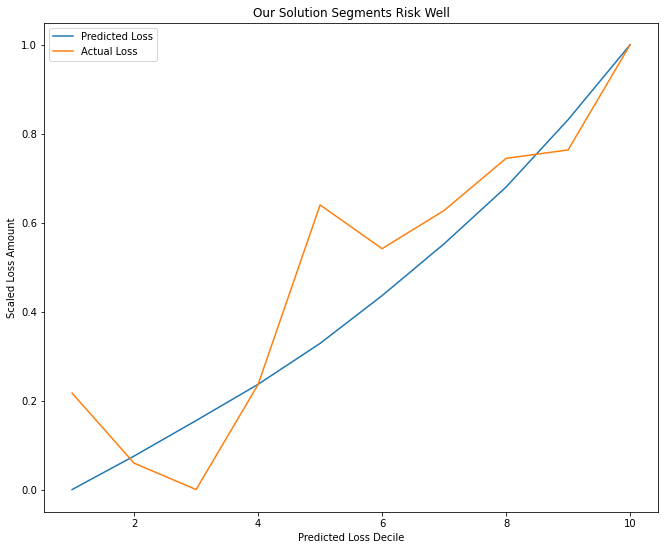

In [23]:
# Lift Chart
df_lift = pd.DataFrame({'y': df['claim_cost'], 'pred': raw_preds}).sort_values('pred')
df_lift['decile'] = pd.qcut(df_lift['pred'], q=10, labels=False) + 1
df_lift = df_lift.groupby('decile').mean().reset_index()

plt.figure(figsize=(11, 9))
plt.plot(df_lift['decile'], minmax_scale(df_lift['pred']), label='Predicted Loss')
plt.plot(df_lift['decile'], minmax_scale(df_lift['y']), label='Actual Loss')
plt.xlabel('Predicted Loss Decile')
plt.ylabel('Scaled Loss Amount')
plt.title('Our Solution Segments Risk Well')
plt.legend()
plt.show()

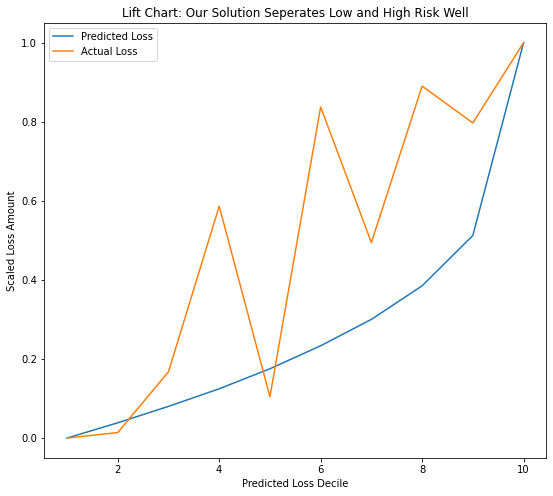

In [24]:
# Lift Chart
df_lift = pd.DataFrame({'y': df['claim_cost'], 'pred': preds}).sort_values('pred')
df_lift['decile'] = pd.qcut(df_lift['pred'], q=10, labels=False) + 1
df_lift = df_lift.groupby('decile').mean().reset_index()

plt.figure(figsize=(9, 8))
plt.plot(df_lift['decile'], minmax_scale(df_lift['pred']), label='Predicted Loss')
plt.plot(df_lift['decile'], minmax_scale(df_lift['y']), label='Actual Loss')
plt.xlabel('Predicted Loss Decile')
plt.ylabel('Scaled Loss Amount')
plt.title('Lift Chart: Our Solution Seperates Low and High Risk Well')
plt.legend()
plt.show()